### Import Statements

In [12]:
import gym
import matplotlib.pyplot as plt

### Create Enviroment

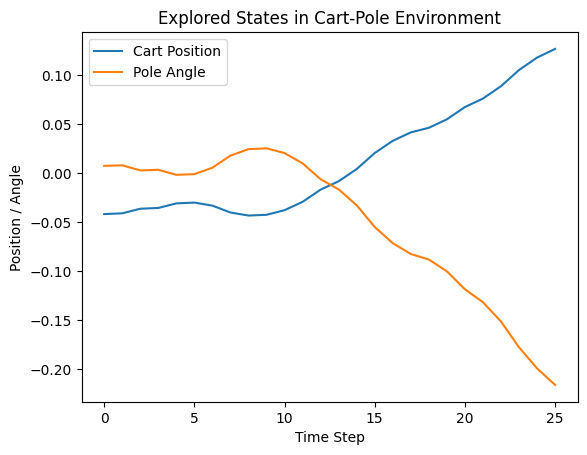

In [21]:
# Create the cart-pole environment
env = gym.make('CartPole-v1')

# Reset the environment to obtain the initial state
state = env.reset()

# Initialize lists to store the positions
cart_positions = [state[0][0]]
pole_positions = [state[0][2]]

# Run a few steps in the environment
for _ in range(100):
    # Choose a random action
    action = env.action_space.sample()

    # Perform the chosen action in the environment
    next_state, reward, terminated, truncated, info = env.step(action)
    
    # Store the positions
    cart_positions.append(next_state[0])
    pole_positions.append(next_state[2])
    
    # Check if the episode is terminated
    if terminated:
        break

# Close the environment
env.close()

# Plot the positions
plt.plot(cart_positions, label='Cart Position')
plt.plot(pole_positions, label='Pole Angle')
plt.xlabel('Time Step')
plt.ylabel('Position / Angle')
plt.title('Explored States in Cart-Pole Environment')
plt.legend()
plt.show()